Loading data from: /kaggle/input/df3333/df3.csv
Initial rows: 2589
Rows after initial preprocessing: 2568

--- Creating Feature Sets ---
Created baseline features (8): ['Adj Close_lag_1', 'Open_lag_1', 'High_lag_1', 'Low_lag_1', 'Close_lag_1', 'Volume_lag_1', 'Log_Return_lag_1', 'Realized_Volatility_Daily_lag_1']
Created rolling features (56): ['Adj Close_lag_1', 'Adj Close_roll_mean_10', 'Adj Close_roll_mean_21']...['Volume_roll_std_21', 'Volume_roll_std_5', 'Volume_roll_std_63']

--- Running Multi-Model Adaptive Forecast with 8 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Adaptive Steps (8 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 492.27 seconds.

--- Running Multi-Model Adaptive Forecast with 56 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)


Adaptive Steps (56 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 2092.64 seconds.

--- Final Evaluation ---

Comparison of Adaptive Forecasts (Basic vs Rolling Features):
Target: Realized_Volatility_Daily
Period: 2022-02-24 to 2025-04-04
----------------------------------------------------------------------
Model & Features          | RMSE       | MAE        | QLIKE     
----------------------------------------------------------------------
LightGBM_Basic            | 5.77       | 3.14       | 0.0088    
LightGBM_Rolling          | 3.82       | 1.84       | 0.0040    
RandomForest_Basic        | 5.62       | 3.16       | 0.0086    
RandomForest_Rolling      | 3.91       | 1.99       | 0.0042    
Ridge_Basic               | 5.59       | 2.91       | 0.0080    
Ridge_Rolling             | 3.90       | 2.14       | 0.0044    
XGBoost_Basic             | 5.76       | 3.40       | 0.0088    
XGBoost_Rolling           | 4.05       | 2.14       | 0.0045    
------------------------------------------------

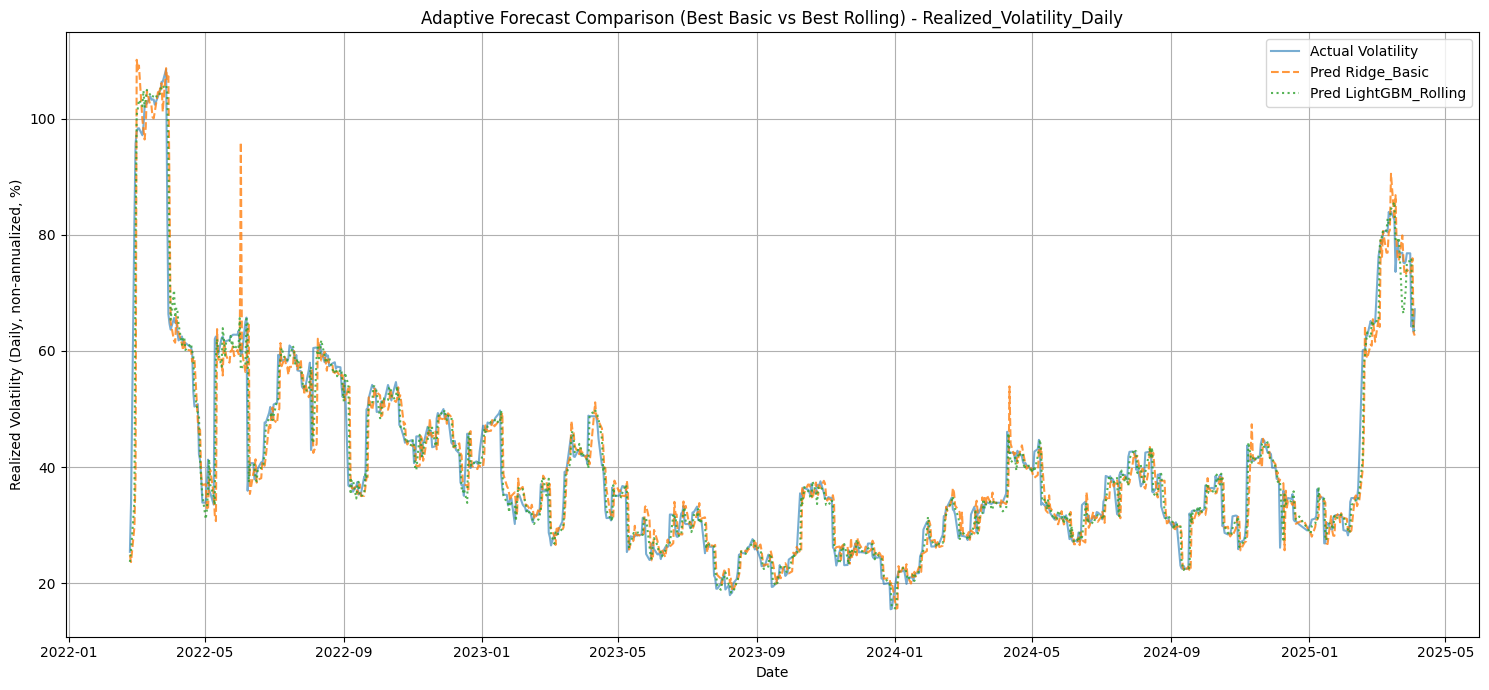

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import time
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

def qlike_loss(y_true, y_pred, epsilon=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = (y_true > epsilon) & (y_pred > epsilon)
    if mask.sum() == 0:
        return np.nan
    y_true, y_pred = y_true[mask], y_pred[mask]
    ratio = y_true / (y_pred + epsilon)
    ratio = np.maximum(ratio, epsilon)
    loss = ratio - np.log(ratio) - 1
    return np.mean(loss)

def add_lag_features(df, target_col, lags):
    df_out = df.copy()
    all_new_features = []
    cols_to_lag = ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume', 'Log_Return', 'Realized_Volatility_Daily']
    if target_col not in cols_to_lag and target_col in df_out.columns:
        cols_to_lag.append(target_col)
    for col in cols_to_lag:
        if col in df_out.columns:
            for lag in lags:
                feature_name = f'{col}_lag_{lag}'
                if feature_name not in df_out.columns:
                    df_out[feature_name] = df_out[col].shift(lag)
                    all_new_features.append(feature_name)
    return df_out, all_new_features

def add_rolling_features(df, windows):
    df_out = df.copy()
    all_new_features = []
    cols_to_roll = ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume', 'High', 'Low']
    for col in cols_to_roll:
         if col in df_out.columns:
            for window in windows:
                mean_feat, std_feat = f'{col}_roll_mean_{window}', f'{col}_roll_std_{window}'
                if mean_feat not in df_out.columns:
                    df_out[mean_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).mean()
                    all_new_features.append(mean_feat)
                if std_feat not in df_out.columns:
                    df_out[std_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).std()
                    all_new_features.append(std_feat)
    return df_out, all_new_features

def run_multi_model_adaptive_forecast(df_full_features, features, target_col, models_to_run, train_end_date, forecast_end_date):
    print(f"\n--- Running Multi-Model Adaptive Forecast with {len(features)} features ---")
    all_predictions = {name: {} for name in models_to_run.keys()}
    start_time_total = time.time()

    forecast_index = df_full_features.loc[train_end_date + pd.Timedelta(days=1):forecast_end_date].index
    forecast_index = forecast_index.unique().sort_values()

    if forecast_index.empty:
        print("No forecast dates found.")
        return {name: pd.Series(dtype=float) for name in models_to_run.keys()}

    print(f"Forecasting from {forecast_index.min().strftime('%Y-%m-%d')} to {forecast_index.max().strftime('%Y-%m-%d')} ({len(forecast_index)} steps)")


    for current_date in tqdm(forecast_index, desc=f"Adaptive Steps ({len(features)} feats)"):
        try:
            current_date_loc = df_full_features.index.get_loc(current_date)
            if current_date_loc == 0:
                continue
            train_end_idx_date = df_full_features.index[current_date_loc - 1]
        except (KeyError, IndexError):
            continue

        current_train_data = df_full_features[df_full_features.index <= train_end_idx_date].copy()
        current_train_data['target_for_train'] = current_train_data[target_col].shift(-1)
        current_train_data.dropna(subset=features + ['target_for_train'], inplace=True)

        if current_train_data.empty:
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        X_train = current_train_data[features]
        y_train = current_train_data['target_for_train']
        X_train.columns = X_train.columns.astype(str)

        try:
            features_for_prediction = df_full_features.loc[[train_end_idx_date]][features]
            features_for_prediction.columns = features_for_prediction.columns.astype(str)
        except KeyError:
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        if features_for_prediction.isnull().any().any():
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        needs_scaling = ['Ridge']
        if any(m in needs_scaling for m in models_to_run):
            scaler = StandardScaler()
            X_train_scaled_np = scaler.fit_transform(X_train.values)
            X_pred_scaled_np = scaler.transform(features_for_prediction.values)



        for model_name, model_config in models_to_run.items():
            model = model_config['model'](**model_config.get('params', {}))

            try:
                if model_name in needs_scaling:
                    model.fit(X_train_scaled_np, y_train)
                    pred = model.predict(X_pred_scaled_np)[0]
                else:
                    model.fit(X_train, y_train)
                    pred = model.predict(features_for_prediction)[0]
                all_predictions[model_name][current_date] = pred
            except Exception:
                 all_predictions[model_name][current_date] = np.nan

    print(f"Finished multi-model adaptive forecast. Total time: {time.time() - start_time_total:.2f} seconds.")
    final_predictions = {name: pd.Series(preds).sort_index() for name, preds in all_predictions.items()}
    return final_predictions

if __name__ == "__main__":
    DATA_FILE_PATH = '/kaggle/input/df3333/df3.csv'
    TARGET_VARIABLE = 'Realized_Volatility_Daily'
    TRAIN_END_DATE = pd.to_datetime("2022-02-23")
    FORECAST_END_DATE = pd.to_datetime("2025-04-04")

    MODELS_TO_RUN = {
        'LightGBM': {
            'model': lgb.LGBMRegressor,
            'params': { 'objective': 'regression_l1', 'metric': 'rmse', 'n_estimators': 200, 'learning_rate': 0.05,
                        'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1,
                        'num_leaves': 15, 'verbose': -1, 'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt' }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor,
            'params': { 'objective': 'reg:squarederror', 'n_estimators': 100, 'learning_rate': 0.1,
                        'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8,
                        'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist' }
        },
        'RandomForest': {
            'model': RandomForestRegressor,
            'params': { 'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 5,
                        'random_state': 42, 'n_jobs': -1 }
        },
        'Ridge': {
            'model': Ridge,
            'params': { 'alpha': 1.0, 'random_state': 42 }
        }
    }

    print(f"Loading data from: {DATA_FILE_PATH}")
    df = pd.read_csv(DATA_FILE_PATH, parse_dates=['Date'], index_col='Date')
    df.sort_index(inplace=True)
    print(f"Initial rows: {len(df)}")
    required_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing required columns: {required_cols}")
    df['Adj Close'] = df['Adj Close'].replace(0, np.nan).ffill()
    df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    window = 21
    annualization_factor = 260
    df['Realized_Volatility_Daily'] = df['Log_Return'].rolling(window=window).std() * np.sqrt(annualization_factor) * 100
    df.dropna(inplace=True)
    print(f"Rows after initial preprocessing: {len(df)}")

    print("\n--- Creating Feature Sets ---")

    df_features_basic = df.copy()
    df_features_basic, BASE_FEATURES_list = add_lag_features(df_features_basic, TARGET_VARIABLE, lags=[1])
    BASE_FEATURES = list(BASE_FEATURES_list)
    print(f"Created baseline features ({len(BASE_FEATURES)}): {BASE_FEATURES}")
    df_features_basic.dropna(subset=BASE_FEATURES, inplace=True)

    df_features_rolling = df.copy()
    df_features_rolling, base_lags = add_lag_features(df_features_rolling, TARGET_VARIABLE, lags=[1])
    df_features_rolling, rolling_features_list = add_rolling_features(df_features_rolling, windows=[5, 10, 21, 63])
    ROLLING_FEATURES = sorted(list(set(base_lags + rolling_features_list)))
    print(f"Created rolling features ({len(ROLLING_FEATURES)}): {ROLLING_FEATURES[:3]}...{ROLLING_FEATURES[-3:]}")
    df_features_rolling.dropna(subset=ROLLING_FEATURES, inplace=True)

    all_preds = {}

    all_preds['Basic'] = run_multi_model_adaptive_forecast(
        df_features_basic, BASE_FEATURES, TARGET_VARIABLE,
        MODELS_TO_RUN, TRAIN_END_DATE, FORECAST_END_DATE
    )

    all_preds['Rolling'] = run_multi_model_adaptive_forecast(
        df_features_rolling, ROLLING_FEATURES, TARGET_VARIABLE,
        MODELS_TO_RUN, TRAIN_END_DATE, FORECAST_END_DATE
    )

    print("\n--- Final Evaluation ---")

    results_flat = {}
    for feature_set, model_preds_dict in all_preds.items():
        for model_name, preds in model_preds_dict.items():
            results_flat[f'{model_name}_{feature_set}'] = preds

    valid_preds = {name: preds for name, preds in results_flat.items() if not preds.empty}
    if not valid_preds:
        print("No valid predictions were generated.")
    else:
        common_index = None
        for preds in valid_preds.values():
            if common_index is None:
                common_index = preds.index
            else:
                common_index = common_index.intersection(preds.index)

        if common_index is None or common_index.empty:
            print("No common index found for predictions.")
        else:
            actuals = df.loc[common_index, TARGET_VARIABLE]
            comparison_df = pd.DataFrame({'Actual': actuals})
            results_metrics = {}

            print("\nComparison of Adaptive Forecasts (Basic vs Rolling Features):")
            print(f"Target: {TARGET_VARIABLE}")
            print(f"Period: {common_index.min().strftime('%Y-%m-%d')} to {common_index.max().strftime('%Y-%m-%d')}")
            print("-" * 70)
            print(f"{'Model & Features':<25} | {'RMSE':<10} | {'MAE':<10} | {'QLIKE':<10}")
            print("-" * 70)

            sorted_names = sorted(valid_preds.keys())

            for name in sorted_names:
                preds = valid_preds[name]
                preds_common = preds.loc[common_index]
                comparison_df[f'Pred_{name}'] = preds_common
                eval_df = comparison_df[['Actual', f'Pred_{name}']].dropna()

                if not eval_df.empty:
                    rmse = mean_squared_error(eval_df['Actual'], eval_df[f'Pred_{name}'], squared=False)
                    mae = mean_absolute_error(eval_df['Actual'], eval_df[f'Pred_{name}'])
                    qlike = qlike_loss(eval_df['Actual'], eval_df[f'Pred_{name}'])
                    results_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'QLIKE': qlike}
                    print(f"{name:<25} | {rmse:<10.2f} | {mae:<10.2f} | {qlike:<10.4f}")
                else:
                     print(f"{name:<25} | {'NaN':<10} | {'NaN':<10} | {'NaN':<10}")

            print("-" * 70)


            best_basic_model = min((m for m in results_metrics if 'Basic' in m), key=lambda k: results_metrics[k]['RMSE'])
            best_rolling_model = min((m for m in results_metrics if 'Rolling' in m), key=lambda k: results_metrics[k]['RMSE'])

            plt.figure(figsize=(15, 7))
            plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual Volatility', alpha=0.6, linewidth=1.5)
            if f'Pred_{best_basic_model}' in comparison_df.columns:
                 plt.plot(comparison_df.index, comparison_df[f'Pred_{best_basic_model}'], label=f'Pred {best_basic_model}', linestyle='--', alpha=0.8)
            if f'Pred_{best_rolling_model}' in comparison_df.columns:
                 plt.plot(comparison_df.index, comparison_df[f'Pred_{best_rolling_model}'], label=f'Pred {best_rolling_model}', linestyle=':', alpha=0.8)

            plt.title(f'Adaptive Forecast Comparison (Best Basic vs Best Rolling) - {TARGET_VARIABLE}')
            plt.xlabel('Date')
            plt.ylabel('Realized Volatility (Daily, non-annualized, %)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('best_basic_vs_rolling_adaptive_forecast.png')
            plt.show()

Loading data from: fullrheinmetal.csv
Initial rows: 2589
Rows after initial preprocessing & feature calculation: 2568

--- Creating Feature Sets ---
  Generating lags for: ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume']
Created baseline features (4)
Rows after basic feature engineering and dropna: 2567
  Generating lags for: ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume']
  Generating rolling features for: ['Adj Close', 'Log_Return', 'Realized_Volatility_Daily', 'Volume']
Created rolling features (36)
Rows after rolling feature engineering and dropna: 2538

--- Running Multi-Model Adaptive Forecast for 'Adj Close' with 4 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)


Adaptive Steps (4 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 213.48 seconds.

--- Running Multi-Model Adaptive Forecast for 'Adj Close' with 36 features ---
Forecasting from 2022-02-24 to 2025-04-04 (795 steps)


Adaptive Steps (36 feats):   0%|          | 0/795 [00:00<?, ?it/s]

Finished multi-model adaptive forecast. Total time: 976.12 seconds.

--- Final Evaluation ---

Comparison of Adaptive Forecasts (Basic vs Rolling Features):
Target: Adj Close
Period: 2022-02-24 to 2025-04-04
--------------------------------------------------
Model & Features          | RMSE       | MAE       
--------------------------------------------------
LightGBM_Basic            | 46.03      | 23.48     
LightGBM_Rolling          | 34.23      | 15.86     
RandomForest_Basic        | 29.85      | 15.00     
RandomForest_Rolling      | 30.33      | 14.80     
Ridge_Basic               | 19.42      | 10.19     
Ridge_Rolling             | 17.28      | 9.23      
XGBoost_Basic             | 33.43      | 17.06     
XGBoost_Rolling           | 19.58      | 10.94     
--------------------------------------------------


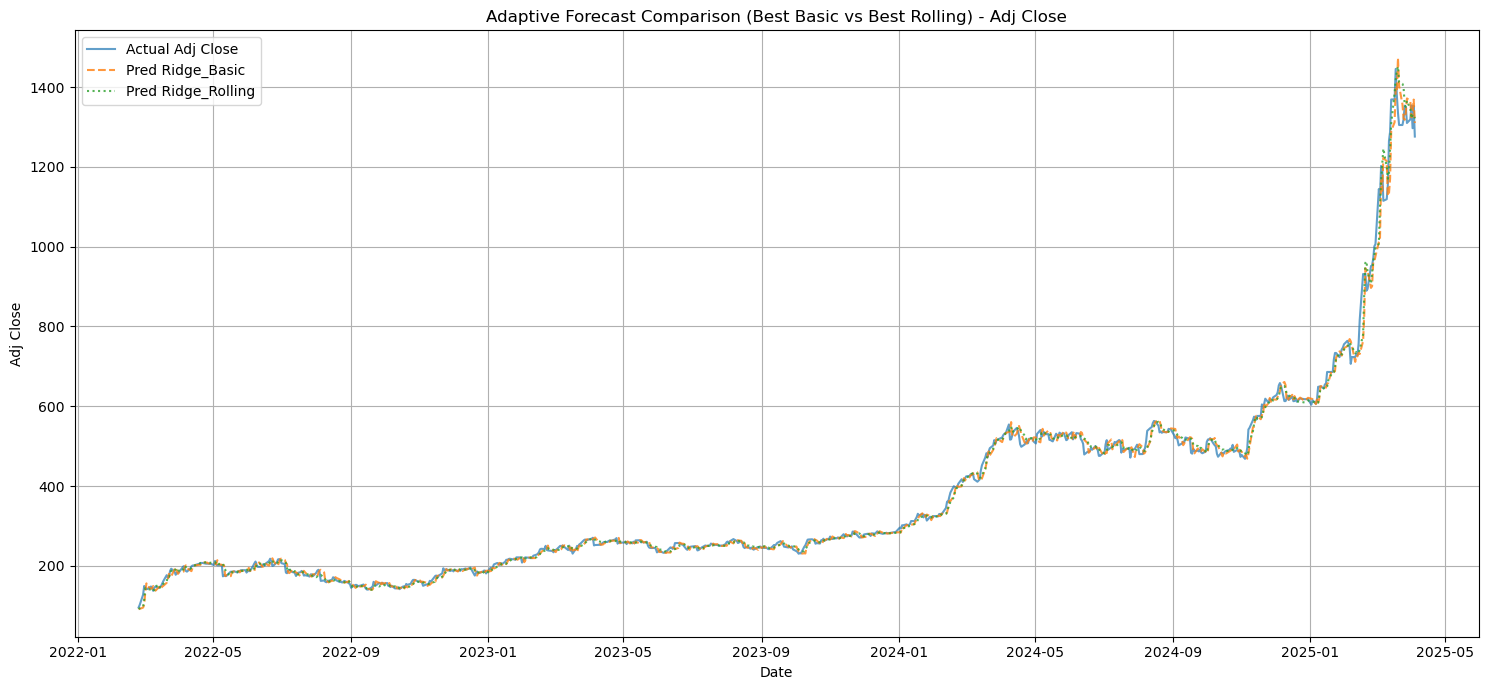

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
import time
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)



def add_lag_features(df, target_col, lags):
    """Dodaje cechy opóźnione dla wybranych kolumn."""
    df_out = df.copy()
    all_new_features = []

    cols_to_lag = ['Adj Close', 'Volume', 'Log_Return']
    if target_col not in cols_to_lag and target_col in df_out.columns:
         cols_to_lag.append(target_col)

    if 'Realized_Volatility_Daily' in df_out.columns:
         cols_to_lag.append('Realized_Volatility_Daily')

    cols_to_lag = sorted(list(set(cols_to_lag)))

    print(f"  Generating lags for: {cols_to_lag}")
    for col in cols_to_lag:
        if col in df_out.columns:
            for lag in lags:
                feature_name = f'{col}_lag_{lag}'
                if feature_name not in df_out.columns:
                    df_out[feature_name] = df_out[col].shift(lag)
                    all_new_features.append(feature_name)
    return df_out, all_new_features

def add_rolling_features(df, windows):
    """Dodaje cechy kroczące (średnia, odch. std.) dla wybranych kolumn."""
    df_out = df.copy()
    all_new_features = []
    cols_to_roll = ['Adj Close', 'Volume', 'Log_Return'] 
    if 'Realized_Volatility_Daily' in df_out.columns:
         cols_to_roll.append('Realized_Volatility_Daily')

    cols_to_roll = sorted(list(set(cols_to_roll)))

    print(f"  Generating rolling features for: {cols_to_roll}")
    for col in cols_to_roll:
         if col in df_out.columns:
            for window in windows:
                mean_feat, std_feat = f'{col}_roll_mean_{window}', f'{col}_roll_std_{window}'
                if mean_feat not in df_out.columns:
                    df_out[mean_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).mean()
                    all_new_features.append(mean_feat)
                if std_feat not in df_out.columns:
                    df_out[std_feat] = df_out[col].rolling(window=window, min_periods=max(1, window // 2)).std()
                    all_new_features.append(std_feat)
    return df_out, all_new_features

def run_multi_model_adaptive_forecast(df_full_features, features, target_col, models_to_run, train_end_date, forecast_end_date):
    print(f"\n--- Running Multi-Model Adaptive Forecast for '{target_col}' with {len(features)} features ---")
    all_predictions = {name: {} for name in models_to_run.keys()}
    start_time_total = time.time()

    forecast_index = df_full_features.loc[train_end_date + pd.Timedelta(days=1):forecast_end_date].index
    forecast_index = forecast_index.unique().sort_values()

    if forecast_index.empty:
        print("No forecast dates found.")
        return {name: pd.Series(dtype=float) for name in models_to_run.keys()}

    print(f"Forecasting from {forecast_index.min().strftime('%Y-%m-%d')} to {forecast_index.max().strftime('%Y-%m-%d')} ({len(forecast_index)} steps)")

    for current_date in tqdm(forecast_index, desc=f"Adaptive Steps ({len(features)} feats)"):
        try:
            current_date_loc = df_full_features.index.get_loc(current_date)
            if current_date_loc == 0: 
                continue
            train_end_idx_date = df_full_features.index[current_date_loc - 1]
        except (KeyError, IndexError):
            continue 

        current_train_data = df_full_features[df_full_features.index <= train_end_idx_date].copy()
        current_train_data['target_for_train'] = current_train_data[target_col].shift(-1)
        current_train_data.dropna(subset=features + ['target_for_train'], inplace=True)

        if current_train_data.empty:
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        X_train = current_train_data[features]
        y_train = current_train_data['target_for_train']
        X_train.columns = X_train.columns.astype(str) 
        
        try:
            features_for_prediction = df_full_features.loc[[train_end_idx_date]][features]
            features_for_prediction.columns = features_for_prediction.columns.astype(str)
        except KeyError:
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        if features_for_prediction.isnull().any().any():
            for model_name in models_to_run.keys():
                all_predictions[model_name][current_date] = np.nan
            continue

        needs_scaling = ['Ridge']
        if any(m in needs_scaling for m in models_to_run):
            scaler = StandardScaler()
            X_train_scaled_np = scaler.fit_transform(X_train.values)
            X_pred_scaled_np = scaler.transform(features_for_prediction.values)

        for model_name, model_config in models_to_run.items():
            model = model_config['model'](**model_config.get('params', {}))

            try:
                if model_name in needs_scaling:
                    model.fit(X_train_scaled_np, y_train)
                    pred = model.predict(X_pred_scaled_np)[0]
                else: 
                    model.fit(X_train, y_train)
                    pred = model.predict(features_for_prediction)[0]
                all_predictions[model_name][current_date] = pred
            except Exception as e:
                 all_predictions[model_name][current_date] = np.nan

    print(f"Finished multi-model adaptive forecast. Total time: {time.time() - start_time_total:.2f} seconds.")
    final_predictions = {name: pd.Series(preds).sort_index() for name, preds in all_predictions.items()}
    return final_predictions

if __name__ == "__main__":
    DATA_FILE_PATH = 'fullrheinmetal.csv'
    TARGET_VARIABLE = 'Adj Close' 
    TRAIN_END_DATE = pd.to_datetime("2022-02-23") 
    FORECAST_END_DATE = pd.to_datetime("2025-04-04")

    MODELS_TO_RUN = {
        'LightGBM': {
            'model': lgb.LGBMRegressor,
            'params': { 'objective': 'regression', 'metric': 'rmse', 'n_estimators': 200, 'learning_rate': 0.05,
                        'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'lambda_l1': 0.1, 'lambda_l2': 0.1,
                        'num_leaves': 15, 'verbose': -1, 'n_jobs': -1, 'seed': 42, 'boosting_type': 'gbdt' }
        },
        'XGBoost': {
            'model': xgb.XGBRegressor,
            'params': { 'objective': 'reg:squarederror', 'n_estimators': 100, 'learning_rate': 0.1,
                        'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8,
                        'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist' }
        },
        'RandomForest': {
            'model': RandomForestRegressor,
            'params': { 'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 5,
                        'random_state': 42, 'n_jobs': -1 }
        },
        'Ridge': {
            'model': Ridge,
            'params': { 'alpha': 1.0, 'random_state': 42 }
        }
    }

    print(f"Loading data from: {DATA_FILE_PATH}")
    df = pd.read_csv(DATA_FILE_PATH, parse_dates=['Date'], index_col='Date')
    df.sort_index(inplace=True)
    print(f"Initial rows: {len(df)}")
    required_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Missing required columns: {required_cols}")

    df['Adj Close'] = df['Adj Close'].replace(0, np.nan).ffill()
    df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    window = 21
    annualization_factor = 260 
    df['Realized_Volatility_Daily'] = df['Log_Return'].rolling(window=window).std()

    df.dropna(subset=['Log_Return', 'Realized_Volatility_Daily'], inplace=True)
    print(f"Rows after initial preprocessing & feature calculation: {len(df)}")

    print("\n--- Creating Feature Sets ---")

    df_features_basic = df.copy()
    df_features_basic, BASE_FEATURES_list = add_lag_features(df_features_basic, TARGET_VARIABLE, lags=[1])
    BASE_FEATURES = list(BASE_FEATURES_list)
    print(f"Created baseline features ({len(BASE_FEATURES)})")
    df_features_basic.dropna(subset=BASE_FEATURES, inplace=True)
    print(f"Rows after basic feature engineering and dropna: {len(df_features_basic)}")


    df_features_rolling = df.copy()
    df_features_rolling, base_lags = add_lag_features(df_features_rolling, TARGET_VARIABLE, lags=[1])
    df_features_rolling, rolling_features_list = add_rolling_features(df_features_rolling, windows=[5, 10, 21, 63])
    ROLLING_FEATURES = sorted(list(set(base_lags + rolling_features_list)))
    print(f"Created rolling features ({len(ROLLING_FEATURES)})")
    df_features_rolling.dropna(subset=ROLLING_FEATURES, inplace=True)
    print(f"Rows after rolling feature engineering and dropna: {len(df_features_rolling)}")


    all_preds = {}

    all_preds['Basic'] = run_multi_model_adaptive_forecast(
        df_features_basic, BASE_FEATURES, TARGET_VARIABLE,
        MODELS_TO_RUN, TRAIN_END_DATE, FORECAST_END_DATE
    )

    all_preds['Rolling'] = run_multi_model_adaptive_forecast(
        df_features_rolling, ROLLING_FEATURES, TARGET_VARIABLE,
        MODELS_TO_RUN, TRAIN_END_DATE, FORECAST_END_DATE
    )

    print("\n--- Final Evaluation ---")

    results_flat = {}
    for feature_set, model_preds_dict in all_preds.items():
        for model_name, preds in model_preds_dict.items():
            results_flat[f'{model_name}_{feature_set}'] = preds

    valid_preds = {name: preds for name, preds in results_flat.items() if not preds.empty}

    if not valid_preds:
        print("No valid predictions were generated by any model/feature set combination.")
    else:
        common_index = None
        for preds in valid_preds.values():
            if common_index is None:
                common_index = preds.index
            else:
                common_index = common_index.intersection(preds.index)

        if common_index is None or common_index.empty:
            print("No common index found for the generated predictions.")
        else:
            actuals = df.loc[common_index, TARGET_VARIABLE]
            comparison_df = pd.DataFrame({'Actual': actuals})
            results_metrics = {} 

            print("\nComparison of Adaptive Forecasts (Basic vs Rolling Features):")
            print(f"Target: {TARGET_VARIABLE}")
            print(f"Period: {common_index.min().strftime('%Y-%m-%d')} to {common_index.max().strftime('%Y-%m-%d')}")
            print("-" * 50)
            print(f"{'Model & Features':<25} | {'RMSE':<10} | {'MAE':<10}")
            print("-" * 50)

            sorted_names = sorted(valid_preds.keys())

            for name in sorted_names:
                preds = valid_preds[name]
                preds_common = preds.loc[common_index]
                comparison_df[f'Pred_{name}'] = preds_common
                eval_df = comparison_df[['Actual', f'Pred_{name}']].dropna()

                if not eval_df.empty:
                    rmse = mean_squared_error(eval_df['Actual'], eval_df[f'Pred_{name}'], squared=False)
                    mae = mean_absolute_error(eval_df['Actual'], eval_df[f'Pred_{name}'])
                    results_metrics[name] = {'RMSE': rmse, 'MAE': mae}
                    print(f"{name:<25} | {rmse:<10.2f} | {mae:<10.2f}") 
                else:
                     print(f"{name:<25} | {'NaN':<10} | {'NaN':<10}")

            print("-" * 50)

            basic_models = [m for m in results_metrics if 'Basic' in m]
            rolling_models = [m for m in results_metrics if 'Rolling' in m]

            best_basic_model = min(basic_models, key=lambda k: results_metrics[k]['RMSE']) if basic_models else None
            best_rolling_model = min(rolling_models, key=lambda k: results_metrics[k]['RMSE']) if rolling_models else None

            plt.figure(figsize=(15, 7))
            plt.plot(comparison_df.index, comparison_df['Actual'], label=f'Actual {TARGET_VARIABLE}', alpha=0.7, linewidth=1.5)

            if best_basic_model and f'Pred_{best_basic_model}' in comparison_df.columns:
                 plt.plot(comparison_df.index, comparison_df[f'Pred_{best_basic_model}'], label=f'Pred {best_basic_model}', linestyle='--', alpha=0.8)
            if best_rolling_model and f'Pred_{best_rolling_model}' in comparison_df.columns:
                 plt.plot(comparison_df.index, comparison_df[f'Pred_{best_rolling_model}'], label=f'Pred {best_rolling_model}', linestyle=':', alpha=0.8)

            plt.title(f'Adaptive Forecast Comparison (Best Basic vs Best Rolling) - {TARGET_VARIABLE}')
            plt.xlabel('Date')
            plt.ylabel(f'{TARGET_VARIABLE}') 
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig('best_basic_vs_rolling_adaptive_price_forecast.png') 
            plt.show()